# RatS Day5 recording info

In [19]:
import numpy as np
import subjects

sess = subjects.tn.ratSday5[0] # add your subject session
print(sess.recinfo)

filename: /data/Clustering/sessions/RatS/Day5TwoNovel/RatS-Day5TwoNovel-2020-12-04_07-55-09.xml 
# channels: 195
sampling rate: 30000
lfp Srate (downsampled): 1250


In [ ]:
sess.paradigm.to_dataframe()

# Animal metadata

In [ ]:
from neuropy.core import animal

d = {'name':'hello','tag':'ser'}

an = animal.Animal(d) 


# Probe configuration
- Add text for details about the probes that were used

## A simple 8 shank probe with same layout across all shanks

In [ ]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe

shanks = []
channel_groups = sess.recinfo.channel_groups
for i in range(8):

    shank = Shank.auto_generate(
        columns=2,
        contacts_per_column=8,
        xpitch=15,
        ypitch=20,
        y_shift_per_column=[0, -7.5],
        channel_id=np.append(
            channel_groups[i][::2][::-1], channel_groups[i][1::2][::-1]
        ),
    )
    shanks.append(shank)
    shank.set_disconnected_channels(sess.recinfo.skipped_channels)

probe1 = Probe(shanks)

prbgrp = ProbeGroup()
prbgrp.add_probe(probe1)

prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
# prbgrp.save()
plot_probe(prbgrp)



## Multiprobe layout

In [ ]:
%matplotlib inline
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe

shanks = []
channel_groups = sess.recinfo.channel_groups
badchans = sess.recinfo.skipped_channels

#--- cambridge probe -----------
for i in range(6):
    chans = channel_groups[i]

    if len(chans)==10:
        n_cont = 5
        y_shift = [0,7.5]
    if len(chans)==11:
        n_cont = [6,5]
        y_shift = [0,7.5]
    if len(chans)==9:
        n_cont = [5,4]
        y_shift = [0,7,5]

    shank = Shank.auto_generate(
        columns=2,
        contacts_per_column=n_cont,
        xpitch=16.5,
        ypitch=15,
        y_shift_per_column=y_shift,
        channel_id=np.append(
            channel_groups[i][1::2][::-1], channel_groups[i][::2][::-1]
        ),
    )
    shank.set_disconnected_channels(sess.recinfo.skipped_channels)
    shanks.append(shank)

probe1 = Probe(shanks)

shanks = []
for i in range(6,14):

    shank = Shank.auto_generate(
        columns=2,
        contacts_per_column=8,
        xpitch=15,
        ypitch=15,
        y_shift_per_column=[0, -7.5],
        channel_id=np.append(
            channel_groups[i][::2][::-1], channel_groups[i][1::2][::-1]
        ),
    )
    shank.set_disconnected_channels(sess.recinfo.skipped_channels)
    shanks.append(shank)


probe2 = Probe(shanks)
probe2.move((probe1.x_max+500,0))

prbgrp = ProbeGroup()
prbgrp.add_probe(probe1)
prbgrp.add_probe(probe2)

prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
# prbgrp.save()
plot_probe(prbgrp)

# Experimental paradigm
A typical experiment involves multiple epochs such pre sleep, running on track and then another sleep epoch.

In [ ]:
import pandas as pd
from neuropy.core import Epoch

epochs = pd.DataFrame(
    {
        "start": [0,11070,20756,13972,24006],
        "stop": [11066,13970,24004,20754,42305],
        "label": ["pre", "maze1", "maze2",'post1','post2'],
    }
)

paradigm = Epoch(epochs=epochs)
paradigm.filename = sess.filePrefix.with_suffix(".paradigm.npy")
paradigm.save()

# Neurons
- import spiketrains from Phy
- estimate neuron types such pyramidal, interneuron etc. 

## Importing spiketrains from Phy

In [ ]:
from neuropy.io import PhyIO
from neuropy.core import Neurons
from pathlib import Path
import numpy as np

cluster_path = Path("/data/Clustering/sessions/RatS/Day5TwoNovel/spykcirc/RatS-Day5TwoNovel-2020-12-04_07-55-09-1.GUI")
chan_grps = sess.recinfo.channel_groups
phy_data = PhyIO(cluster_path)
spiketrains =phy_data.spiketrains
peak_chans = phy_data.peak_channels
waveforms = phy_data.waveforms
shank_id = sess.probegroup.get_shank_id_for_channels(peak_chans)

neuron_type_id = phy_data.cluster_info.q.values
neuron_type = np.ones(len(neuron_type_id), dtype="U5")
neuron_type[neuron_type_id<4] = 'pyr'
neuron_type[neuron_type_id==6] = 'mua'
neuron_type[neuron_type_id==8] = 'inter'


neurons = Neurons(
    np.array(spiketrains, dtype=object),
    t_stop=sess.eegfile.duration,
    sampling_rate=phy_data.sampling_rate,
    peak_channels=peak_chans,
    waveforms=np.array(waveforms,dtype='object'),
    shank_ids=np.array(shank_id).astype(int),
    neuron_type = neuron_type,
)

neurons.filename = sess.filePrefix.with_suffix('.neurons')
neurons.save()



### Plot raster

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
from neuropy.plotting import plot_raster

plot_raster(neurons,color='jet',add_vert_jitter=True)

In [ ]:
from neuropy.plotting import plot_waveforms

plot_waveforms(sess.neurons)

## BinnedSpiketrain and Mua objects using Neurons

In [ ]:
mua =sess.neurons.get_mua()
mua.filename = sess.filePrefix.with_suffix(".mua.npy")
mua.save()   


In [ ]:
%matplotlib widget
from neuropy import plotting
smth_mua = sess.mua.get_smoothed(sigma=0.02)
plotting.plot_mua(smth_mua)

# Detect epochs
Here we will various types of epochs which typical for hippocampal recordings.

## Artifacts
A typical session will have some artifacts that may negatively influence many analyses. Using a simple zscore measure, we can identify epochs where signal is above some threshold.

In [ ]:
signal = sess.eegfile.get_signal([1])
artifact_epochs = analyses.detect_artifact_epochs(signal, thresh=7)
artifact_epochs.filename = sess.filePrefix.with_suffix(".artifact.npy")
artifact_epochs.save()
plotting.plot_artifact_epochs(artifact_epochs, signal)

## Ripple
To detect ripples one also needs probegroup.

In [4]:
from neuropy.analyses import oscillations
signal = sess.eegfile.get_signal()
ripple_epochs =oscillations.detect_ripple_epochs(signal, sess.probegroup)
ripple_epochs.filename = sess.filePrefix.with_suffix('.ripple.npy')
ripple_epochs.save()

Selected channels for ripples: [5, 1, 13, 50, 44, 75, 91, 100, 123, 131, 148, 166, 180]
1197333 epochs detected initially
139621 epochs reamining after merging close ones
19888 epochs reamining after deleting epochs with weaker power
19709 epochs reamining after deleting short epochs
13811 epochs reamining after deleting very long epochs
RatS-Day5TwoNovel-2020-12-04_07-55-09.ripple.npy saved


## Pbe

In [ ]:
from neuropy.analyses import detect_pbe_epochs

pbe = detect_pbe_epochs(smth_mua)
pbe.filename = sess.filePrefix.with_suffix('.pbe')
pbe.save()


# Assign position data

In [17]:
from neuropy.io import OptitrackIO
from neuropy.core import Position
from pathlib import Path

opti_folder = sess.filePrefix.parent / 'position'
opti_data = OptitrackIO(dirname=opti_folder)

/data/Clustering/sessions/RatS/Day5TwoNovel/position/Take 2020-12-04 11.11.32 AM.csv
/data/Clustering/sessions/RatS/Day5TwoNovel/position/Take 2020-12-04 11.53.36 AM.csv
/data/Clustering/sessions/RatS/Day5TwoNovel/position/Take 2020-12-04 02.05.58 PM.csv
/data/Clustering/sessions/RatS/Day5TwoNovel/position/Take 2020-12-04 02.13.28 PM.csv


In [18]:
import pandas as pd
from datetime import datetime

#---- startimes of concatenated .dat files
tracking_sRate = opti_data.sampling_rate
rec_datetime = pd.read_csv(sess.filePrefix.with_suffix('.datetime.csv'))
data_time = []
for i, file_time in enumerate(rec_datetime["StartTime"]):
    # sync_time = rec_datetime['sync_nframes'][i]/rec_datetime['sync_rate'][i]
    tbegin = datetime.strptime(file_time, "%Y-%m-%d_%H-%M-%S")
    nframes = rec_datetime["nFrames"][i]
    duration = pd.Timedelta(nframes / sess.recinfo.dat_sampling_rate, unit="sec")
    tend = tbegin + duration
    trange = pd.date_range(
        start=tbegin,
        end=tend,
        periods=int(duration.total_seconds() * tracking_sRate),
    )
    data_time.extend(trange)
data_time = pd.to_datetime(data_time)

# # ------- deleting intervals that were deleted from .dat file after concatenating
# ndeletedintervals = rec_datetime.count()["deletedStart (minutes)"]
# for i in range(ndeletedintervals):
#     tnoisy_begin = data_time[0] + pd.Timedelta(
#         rec_datetime["deletedStart (minutes)"][i], unit="m"
#     )
#     tnoisy_end = data_time[0] + pd.Timedelta(
#         rec_datetime["deletedEnd (minutes)"][i], unit="m"
#     )

#     del_index = np.where((data_time > tnoisy_begin) & (data_time < tnoisy_end))[
#         0
#     ]

#     data_time = np.delete(data_time, del_index)

x,y,z = opti_data.get_position_at_datetimes(data_time)
traces = np.vstack((z,x,y))

position = Position(traces=traces,t_start=0,sampling_rate=opti_data.sampling_rate)
position.filename = sess.filePrefix.with_suffix('.position.npy')
position.save()

RatS-Day5TwoNovel-2020-12-04_07-55-09.position.npy saved


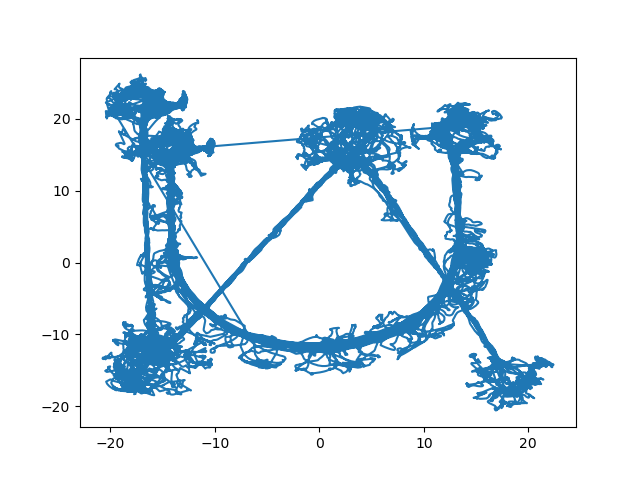

In [16]:
%matplotlib widget
import matplotlib.pyplot as plt

# plt.plot(opti_data.datetime_array,opti_data.z)
plt.plot(sess.position.x,sess.position.y)

In [ ]:
%matplotlib widget
from neuropy.utils import signal_process

signal = sess.eegfile.get_signal([40])

spec = signal_process.spectrogramBands(signal.traces[0])


In [ ]:
%matplotlib widget

import matplotlib.pyplot as plt

plt.plot(spec.time,spec.theta/500)
plt.plot(sess.position.time,sess.position.y)
plt.plot(sess.position.time[1:],np.diff(sess.position.y)*100)
plt.xlim([12500,12600])
plt.ylim([-400,400])

## Linearize position

In [22]:
from neuropy.utils import position_util

maze = sess.paradigm['maze2']
maze_pos = sess.position.time_slice(maze[0],maze[1])
linear_pos = position_util.linearize_position(maze_pos)

/home/bapung/miniconda3/envs/data_analysis/lib/python3.9/site-packages/sklearn/manifold/_isomap.py:302: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/bapung/miniconda3/envs/data_analysis/lib/python3.9/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [23]:
linear_pos.filename = sess.filePrefix.with_suffix('.maze2.linear')
linear_pos.save()

RatS-Day5TwoNovel-2020-12-04_07-55-09.maze2.linear saved


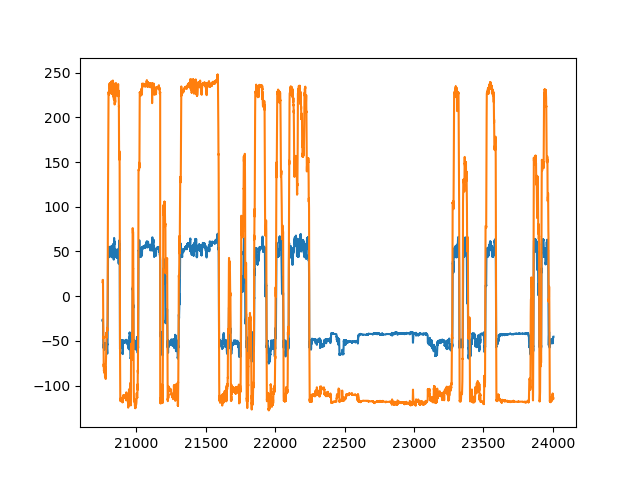

In [24]:
%matplotlib widget
import matplotlib.pyplot as plt

plt.plot(maze_pos.time,maze_pos.x)
plt.plot(linear_pos.time,linear_pos.x)